In [1]:
from jax import numpy as jnp, random, vmap
import thermox
import diffrax
from time import time
import matplotlib.pyplot as plt

We want to simulate an OU process
$$
dx = -A(x-b)dt + \mathcal{N}(0, Ddt)
$$
and compare `thermox` and `diffrax` for a varying number of timesteps.

In [2]:
# Define dimension
dim = 100

In [3]:
# Master key
key = random.PRNGKey(0)

In [4]:
# Function to generate a random wishart matrix
def sample_wishart(key, dim, df):
    G = random.normal(key, (dim, df))
    return G @ G.T

In [5]:
# Generate A from Wishart distribution
key, A_key = random.split(key)
df_A = 10
A = sample_wishart(A_key, dim, df_A)

# Perturb to ensure it is positive definite
A += 1e-3 * jnp.eye(dim)


In [6]:
# Generate x0 and b from normal distribution
key, x0_key, b_key = random.split(key, 3)
x0 = random.normal(x0_key, (dim,))
b = random.normal(b_key, (dim,))

In [7]:
# Identity D
D = jnp.eye(dim)
D_sqrt = jnp.linalg.cholesky(D)

In [8]:
# Function to simulate from thermox
def simulate_thermox(rk, ts):
    return thermox.sample(rk, ts, x0, A, b, D, A_spd=True)

In [58]:
# Function to simulate from diffrax
def simulate_diffrax(rk, ts):
    # From https://docs.kidger.site/diffrax/usage/getting-started/#stochastic-differential-equations-sdes
    def drift(t, y, args):
        return -A @ (y - b)
    def diffusion(t, y, args):
        return D_sqrt
    brownian_motion = diffrax.VirtualBrownianTree(ts[0], ts[-1], tol=1e-3, shape=(dim,), key=rk)
    terms = diffrax.MultiTerm(diffrax.ODETerm(drift), diffrax.ControlTerm(diffusion, brownian_motion))
    solver = diffrax.ItoMilstein()
    saveat = diffrax.SaveAt(dense=True)
    sol = diffrax.diffeqsolve(terms, solver, ts[0], ts[-1], y0=x0, saveat=saveat,
                               dt0=0.01, max_steps=10000000,
                               )
    return vmap(lambda t: sol.evaluate(t))(ts)

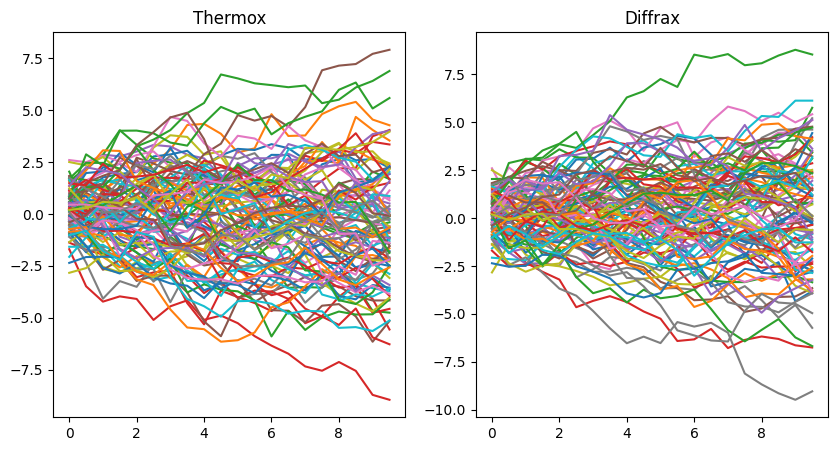

In [59]:
# Validate the two simulators
ts = jnp.arange(0, 10, 0.5)
# ts = random.uniform(key, (100,), minval=0, maxval=10).sort()
thermox_samples = simulate_thermox(key, ts)
diffrax_samples = simulate_diffrax(key, ts)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(ts, thermox_samples)
axes[0].set_title("Thermox")
axes[1].plot(ts, diffrax_samples)
axes[1].set_title("Diffrax");

In [64]:
# Time the two simulators
T_range = [10, 100, 1000, 10000, 100000]

thermox_times = []
diffrax_times = []

for T in T_range:
    ts = jnp.linspace(0, 10, T)

    # Thermox
    start = time()
    vals_t = simulate_thermox(key, ts).block_until_ready()
    end = time()
    thermox_times.append(end - start)
    
    # Diffrax
    start = time()
    vals_d = simulate_diffrax(key, ts).block_until_ready()
    end = time()
    diffrax_times.append(end - start)
    

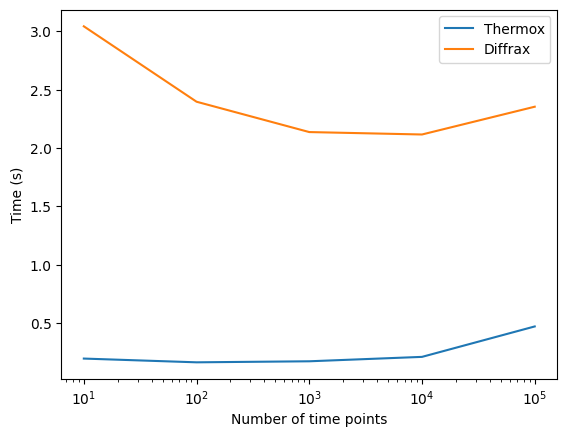

In [65]:
plt.plot(T_range, thermox_times, label="Thermox")
plt.plot(T_range, diffrax_times, label="Diffrax")
plt.xlabel("Number of time points")
plt.ylabel("Time (s)")
plt.legend()
plt.xscale("log");

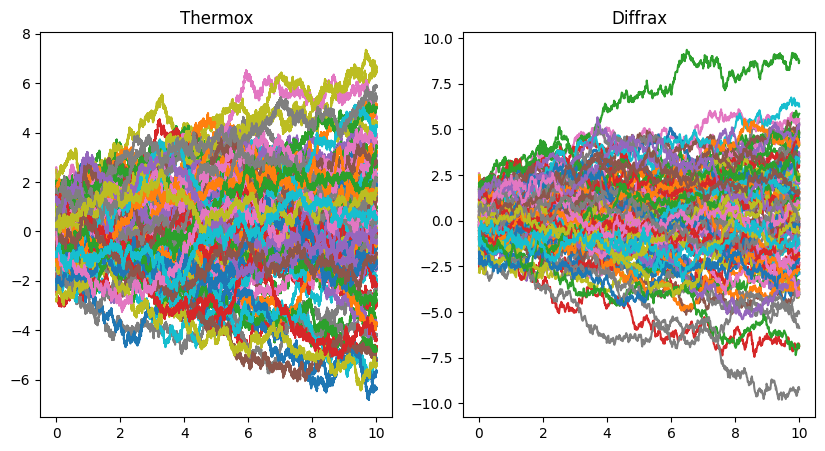

In [66]:
# Sanity check the final runs are legit

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(ts, vals_t)
axes[0].set_title("Thermox")
axes[1].plot(ts, vals_d)
axes[1].set_title("Diffrax");